Envoyer à nicolas.salvy@inria.fr
\
LSD_TP2_Name1_Name2
\
Deadline January 23rd pour part 1 et part 2 ensemble

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

## Generation of synthetic data

In [2]:
Tmin=1
Tmax=1000
N=200

def T(n, N, Tmin, Tmax):
    return Tmin*np.exp(-(n-1)*np.log(Tmin/Tmax)/(N-1))

T_values = [T(n, N, Tmin, Tmax) for n in range(1, N+1)]

In [47]:
with open('signal.txt', 'r') as file:
    original_signal = file.read()

original_signal = list(map(float, original_signal.split()))
x = pd.DataFrame(original_signal, index=T_values, columns=['Valeur'])

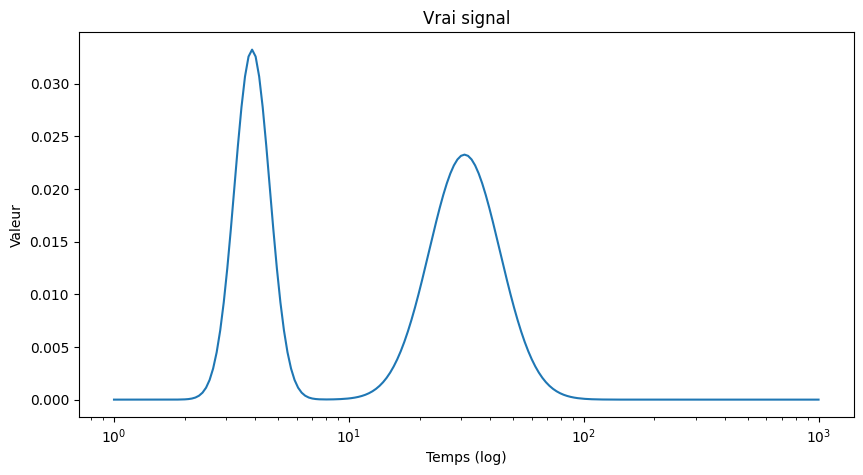

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(x)
plt.xscale('log')
plt.title('Vrai signal')
plt.ylabel('Valeur')
plt.xlabel('Temps (log)')
plt.show()

In [5]:
M=50
tmin=0
tmax=1.5

def t(m, M, tmin, tmax):
    return tmin + (m-1)*(tmax-tmin)/(M-1)

t_values = [t(m, M, tmin, tmax) for m in range(1, M+1)]


In [6]:
K = np.exp(-np.outer(t_values, T_values))

In [7]:
z = K @ x.values
sigma = 0.01*z[0]
w = np.random.normal(0, sigma, M).reshape(-1, 1)

noisy_signal = z + w
noisy_signal_df = pd.DataFrame(noisy_signal, index=t_values, columns=['Valeur'])

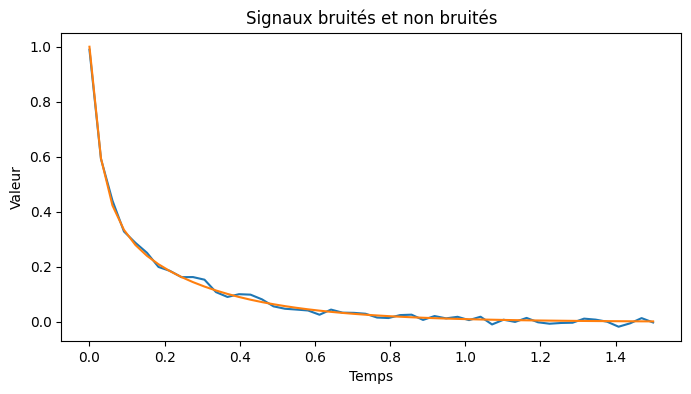

In [8]:
plt.figure(figsize=(8,4))
plt.plot(t_values, noisy_signal_df, label='Signal bruité')
plt.plot(t_values, z, label='Signal originel')
plt.title('Signaux bruités et non bruités')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.show()

## Comparison of regularization strategies

$ x = \argmin  \frac{1}{2} \|Kx-y\|^2 + \beta g(x) $

On pose $G(x) = \frac{1}{2} \|Kx-y\|^2 + \beta g(x) $

## Smoothness prior : 
$$g(x) = \frac{1}{2} \|Dx\|^2 $$

$R^N$ est convexe. 
G est continue et coercive, il existe donc un minimum. 
De plus, G est strictment convexe, il y a donc unicité de ce minimum.

On peut résoudre explicitement ce problème de minimisation.

$\nabla G(x) = K^T(Kx - y) + \beta D^TDx$

Ainsi, le $x$ optimal, annulant ce gradient est :
$x_{min} = (K^TK + \beta D^TD)^{-1}K^Ty$

In [9]:
from scipy.linalg import circulant, inv

D = np.zeros(N)
c = np.zeros(N)
c[0] = 1
c[1] = -1
D = circulant(c)

def smoothness_prior(y, beta):
    matr = K.T @ K + beta * D.T @ D
    return inv(matr) @ K.T @ y

x_opt = smoothness_prior(noisy_signal, 0.1)

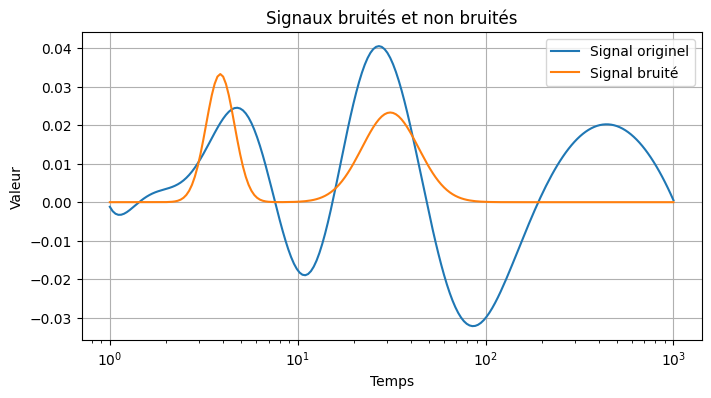

In [10]:
plt.figure(figsize=(8,4))
plt.plot(T_values, x_opt, label='Signal originel')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

In [11]:
def error(x, x_opt):
    num = np.linalg.norm(x - x_opt)**2
    denom = np.linalg.norm(x)**2
    return num/denom

print(f'Normalized quadratic error: {error(x.values, x_opt):2f}')

Normalized quadratic error: 2.326814


Best beta: 1.53 Error: 0.20


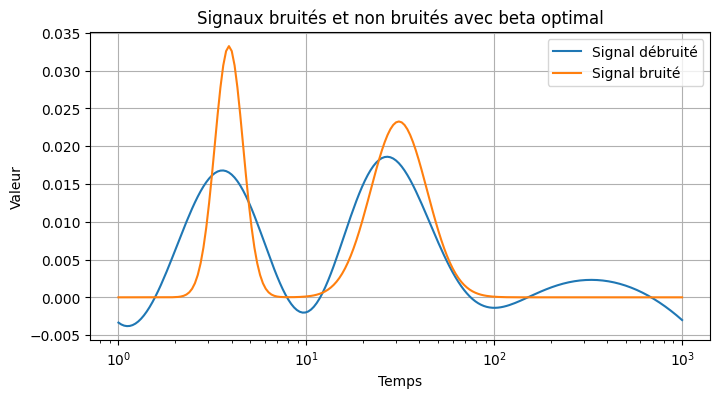

In [12]:
beta_values = np.logspace(-3, 3, 50)  # Test beta values from 0.001 to 1000
errors = []

for beta in beta_values:
    x_opt = smoothness_prior(noisy_signal, beta)
    quadratic_err = error(x.values, x_opt)
    errors.append(quadratic_err)

best_beta = beta_values[np.argmin(errors)]
best_signal = smoothness_prior(noisy_signal, best_beta)
associated_error = error(x.values, best_signal)
print(f'Best beta: {best_beta:.2f}', f'Error: {associated_error:.2f}')

plt.figure(figsize=(8,4))
plt.plot(T_values, best_signal, label='Signal débruité')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités avec beta optimal')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

## Smoothness prior + constraints :



$ g(x) = \frac{1}{2} \|Dx\|^2 + ι_{[x_{min}, x_{max}]^N} (x) $

Contrainte ajoutée : $ x \in [x_{min}, x_{max}]^N $

L'ensemble de départ est un ensemble fermé borné de  $R^N$. G y est continue, il existe donc un minimum.
 
De plus, G est strictment convexe, il y a donc unicité de ce minimum.

Pour résoudre ce problème, on utilise l'algorithme du gradient projeté, car $ x \in [x_{min}, x_{max}]^N $ est un ensemble fermé convexe.

$\nabla G(x) = K^T(Kx - y) + \beta D^TDx$

Ce gradient est lipschitzien, de constante $||K||^2 + \beta ||D||^2$


In [13]:
def gradient_g(y, x, beta):
    matr = K.T @ K + beta * D.T @ D
    return matr @ x - K.T @ y

def gradient_g_for_descent(y, x, matr):
    return matr @ x - K.T @ y

def gradient_projete(y, x0, beta, max_iter=10000, threshold=1e-6):
    # Initialisation des paramètres :
    x_curr = x0
    xmin = np.min(x.values)
    xmax = np.max(x.values)
    L = np.linalg.norm(K, ord=2)**2 + beta * np.linalg.norm(D, ord=2)**2
    gamma = 1.5/L
    delta = 2-gamma*L/2
    lambd = delta/2

    matr = K.T @ K + beta * D.T @ D

    for iter in range(max_iter):
        gradient = gradient_g_for_descent(y, x_curr, matr)
        z = np.clip(x_curr - gamma * gradient, xmin, xmax)
        x_curr += lambd * (z - x_curr)
        if np.linalg.norm(gradient) < threshold:
            print(f'Convergence atteinte en {iter} itérations')
            break
    return x_curr

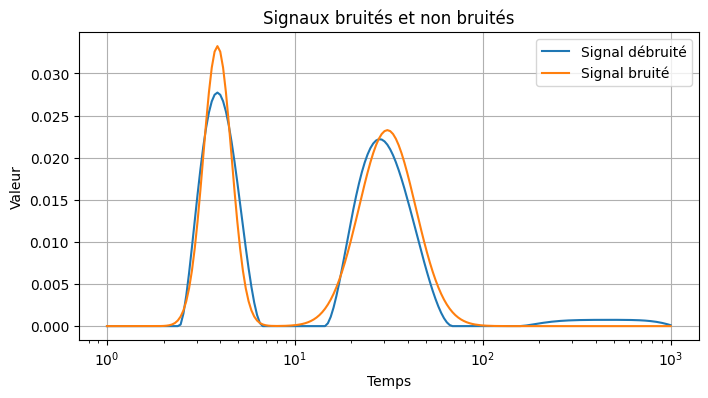

In [14]:
x0 = np.zeros(N).reshape(-1, 1)
x_opt = gradient_projete(noisy_signal, x0, 0.5, 50000)

plt.figure(figsize=(8,4))
plt.plot(T_values, x_opt, label='Signal débruité')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

Évaluation des erreurs: 100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


Best beta: 0.596 Error: 0.03


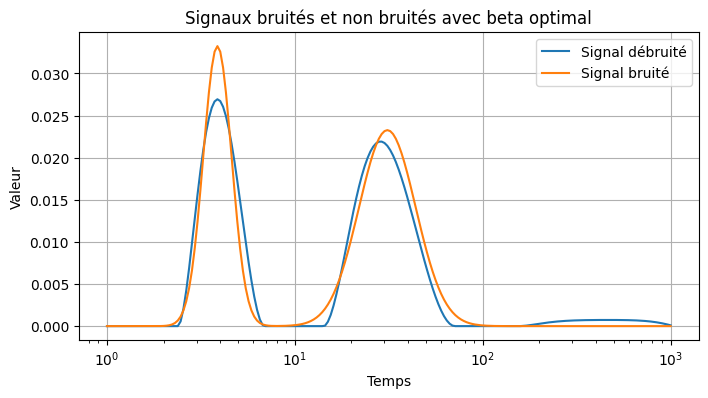

In [15]:
beta_values = np.logspace(-3, 1, 50)  # Test beta values from 0.001 to 1000
errors = []

for beta in tqdm.tqdm(beta_values, desc="Évaluation des erreurs"):
    x_opt = gradient_projete(noisy_signal, x0, beta, 50000)
    quadratic_err = error(x.values, x_opt)
    errors.append(quadratic_err)

best_beta = beta_values[np.argmin(errors)]
best_signal = gradient_projete(noisy_signal, x0, best_beta, 50000)
associated_error = error(x.values, best_signal)
print(f'Best beta: {best_beta:.3f}', f'Error: {associated_error:.2f}')

plt.figure(figsize=(8,4))
plt.plot(T_values, best_signal, label='Signal débruité')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités avec beta optimal')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

## Sparsity prior :



$∀x \in R^N, g(x) = ||x||_1$

$R^N$ est convexe. 
G est continue et coercive, il existe donc un minimum. 
De plus, G est strictment convexe, il y a donc unicité de ce minimum.

Algorithme du gradient projeté :

G est lipschitzienne de constante $L = ||K||^2 + \beta$

In [16]:
def gradient_g_sparse(x, beta, KTK, matr_y):
    return KTK @ x - matr_y + beta * np.sign(x)

def gradient_projete_sparse(y, x0, beta, max_iter=50000, threshold=1e-6):
    # Initialisation des paramètres :
    x_curr = x0
    L = np.linalg.norm(K, ord=2)**2 + beta
    gamma = 1.5/L
    delta = 2-gamma*L/2
    lambd = delta/2

    KTK = K.T @ K
    matr_y = K.T @ y
    for iter in range(max_iter):
        gradient = gradient_g_sparse(x_curr, beta, KTK, matr_y)
        z = x_curr - gamma * gradient
        x_curr += lambd * (z - x_curr)
        if np.linalg.norm(gradient) < threshold:
            print(f'Convergence atteinte en {iter} itérations')
            break
    return x_curr

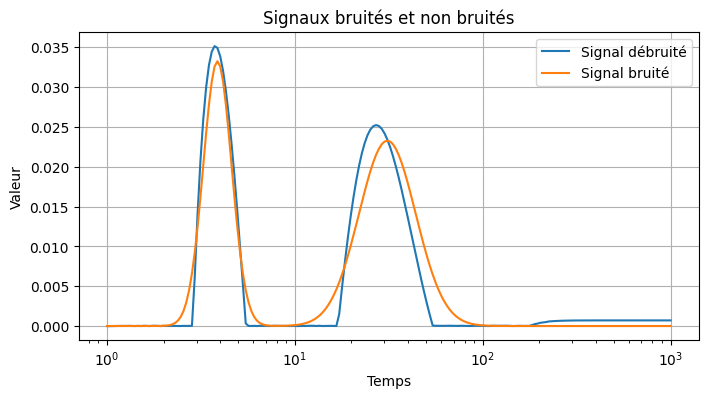

In [17]:
x0 = np.zeros(N).reshape(-1, 1)
x_opt = gradient_projete_sparse(noisy_signal, x0, 0.01, 50000, 1e-8)

plt.figure(figsize=(8,4))
plt.plot(T_values, x_opt, label='Signal débruité')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

Évaluation des erreurs: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


Best beta: 0.001 Error: 0.30


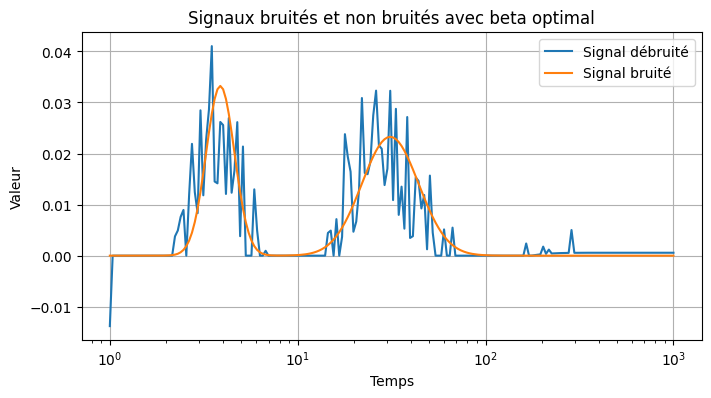

In [18]:
beta_values = np.logspace(-3, 1, 50)  # Test beta values from 0.001 to 1
errors = []

for beta in tqdm.tqdm(beta_values, desc="Évaluation des erreurs"):
    x_opt = gradient_projete_sparse(noisy_signal, x0, beta, 50000, 1e-8)
    quadratic_err = error(x.values, x_opt)
    errors.append(quadratic_err)

best_beta = beta_values[np.argmin(errors)]
best_signal = gradient_projete_sparse(noisy_signal, x0, best_beta, 50000, 1e-8)
associated_error = error(x.values, best_signal)
print(f'Best beta: {best_beta:.3f}', f'Error: {associated_error:.2f}')

plt.figure(figsize=(8,4))
plt.plot(T_values, best_signal, label='Signal débruité')
plt.plot(T_values, x, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités avec beta optimal')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()

## Part 2

### Q1

For any $u \in \mathbb{R}_+^*$, $\phi'(u) = 1 + \ln(u)$ is strictly non-decreasing, so $\phi$ is strictly convex on $\mathbb{R}_+^*$.  

Then, we add $\iota_{\mathbb{R}_+}$, which is also convex and continuously extend $\phi$ at $0$.  

This concludes that $\phi$ is strictly convex and, therefore, $\text{ent}$ is strictly convex as a sum of strictly convex functions.  

Then, $\phi$ is lower semi-continuous since its epigraph is closed, which makes $\text{ent}$ a lower semi-continuous function as a sum of l.s.c. functions.  

Since $\phi$ is proper, $\text{ent}$ is also proper.  

$\phi$ is differentiable on $\mathopen{]}0, +\infty\mathclose{[}^N$ so $\text{ent}$ is also differentiable on $\mathopen{]}0, +\infty\mathclose{[}^N$


### Q2

We have shown that $\text{ent}$ is l.s.c and strictly convex. On top of that, noticing that $\phi$  is coercive, we conclude that $\text{ent}$ is coercive as well. 

Therefore, Weierstrass theorem ensures that the problem has a solution and the strict convexity ensures the **uniqueness of the solution.**

### Q3

Let $x \in \mathbb{R}^N$,
$$
\text{prox}_{\text{ent}}(x) = \arg \min_{y \in \mathbb{R}_+^N} \sum_{i=1}^N \left( y_i \log y_i + \frac{(y_i - x_i)^2}{2} \right).
$$

We can therefore separate this into $N$ distinct problems. Let $i \in [1, N]$. 

Taking the derivative with respect to $y_i$ and setting it to zero yields:
$$
1 + \log y_i - x_i + y_i = 0
$$
i.e.,
$$
y_i + \log y_i = x_i - 1.
$$

Let $z = y_i$, we then have
$$
z e^z = e^{x_i - 1}.
$$

This means that $y_i := W(\exp(x_i - 1))$ where $W$ is the Lambert $W$ function. 

Noticing that $W(x) \geq 0$ for $x \geq 0$, this is a valid solution.

Putting it together, we conclude that
$$
\text{prox}_{\text{ent}}(x) = W(e^{x - 1}),
$$
where $W$ is applied element-wise.


### Q4

In [19]:
import warnings
from scipy.special import lambertw

def ent(x: np.ndarray) -> float:
    def phi(x_n: float) -> float:
        return x_n * np.log(x_n) if x_n > 0 else 0 if x_n == 0 else np.inf

    phi_vectorized = np.vectorize(phi, otypes=[float])
    return np.sum(phi_vectorized(x))

# Compute the proximal operator of gamma * ent
def prox_ent(x: np.ndarray, gamma: float) -> np.ndarray:        
    return gamma * np.real(lambertw(np.exp(x/gamma - 1)))

def squared_loss(K: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    return 0.5 * np.linalg.norm(K @ x - y)**2

def gradient_squared_loss(K: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return K.T @ (K @ x - y.reshape(-1))

def total_loss(K: np.ndarray, x: np.ndarray, y: np.ndarray, beta: float) -> float:
    return squared_loss(K, x, y) + beta * ent(x)

[np.float64(256.85391197598693), np.float64(93.97167752291543), np.float64(70.17090878534594), np.float64(59.96909481420882), np.float64(54.49058164582335), np.float64(51.23679466153686), np.float64(49.19734504983338), np.float64(47.879653685922015), np.float64(47.013792935445665), np.float64(46.440390168121716)]
[np.float64(-0.10591162837541167), np.float64(-0.06322557966126661), np.float64(-0.049858533850562284), np.float64(-0.04159093119843082), np.float64(-0.03562210019281867), np.float64(-0.030994067045961513), np.float64(-0.027261794240849763), np.float64(-0.02418063087555801), np.float64(-0.02159666447195292), np.float64(-0.019401888098558032)]
[np.float64(256.9598236043623), np.float64(94.03490310257669), np.float64(70.22076731919651), np.float64(60.01068574540725), np.float64(54.526203746016165), np.float64(51.26778872858282), np.float64(49.22460684407423), np.float64(47.90383431679757), np.float64(47.035389599917615), np.float64(46.45979205622027)]


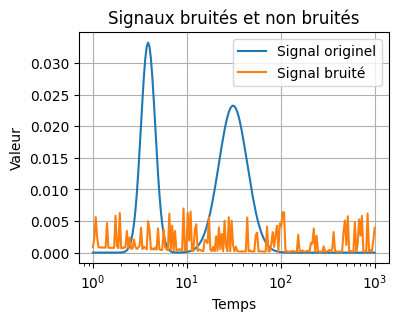

In [55]:
def fb(x0: np.array, gamma0: float, lambda0:float, beta: float, n_iter: int) -> np.array:
    x_fb = x0
    loss_history = []
    beta_loss_history = []
    squared_loss_history = []
    x_history = []
    for i in range(n_iter):
        gamma = gamma0/(np.log(i+2))
        lambda_ = lambda0/np.log((i+3))
        y_fb = x_fb - (gamma) * gradient_squared_loss(K, x_fb, noisy_signal)
        # y_fb = np.clip(y_fb, 0, None)
        x_fb += (lambda_) * (prox_ent(y_fb, gamma) - x_fb)
        x_fb = np.clip(x_fb, 0, None)
        if i%10 == 0:
            beta_loss_history.append(beta * ent(x_fb))
            squared_loss_history.append(squared_loss(K, x_fb, noisy_signal))
            loss_history.append(total_loss(K, x_fb, noisy_signal, beta))
            x_history.append(x_fb)
    return x_fb, loss_history, x_history, beta_loss_history, squared_loss_history
        
x0 = np.random.uniform(0, np.max(x), N)
gamma0 = 0.001
lambda0 = 0.5
n_iter = 100
beta = 1e-2
x_fb, loss_history, x_history, beta_loss_history, squared_loss_history = fb(x0, gamma0, lambda0, beta, n_iter)
print(loss_history)
print(beta_loss_history)
print(squared_loss_history)

plt.figure(figsize=(4,3))
plt.plot(T_values, x, label='Signal originel')
plt.plot(T_values, x_fb, label='Signal bruité')
plt.xscale('log')
plt.title('Signaux bruités et non bruités')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.grid()
plt.show()